## Writing Data

This notebook demonstrates how to use DL1 Data Handler to write/read MAGIC data for use in machine learning analysis in Python.

In [2]:
from dl1_data_handler.writer import DL1DataWriter, CTAMLDataDumper

In [3]:
runlist = [
    {
        'inputs': ["/.../GA_M*_za05to35_8_821319_Y_w0.root"],
        'target': "/.../GA_M*_za05to35_8_821319_Y_w0.h5"
    },
]


print("Number of input files in runlist: {}".format(
    len([input_file for run in runlist for input_file in run['inputs']])))
print("Number of output files requested: {}".format(
    len(runlist)))

Number of input files in runlist: 1
Number of output files requested: 1


Firstly, for each event, data is read from the ROOT files using MAGICEventSource implemented and called in DL1DataWriter. Then, this data is sent to the CTAMLDataDumper to dump the data to a HDF5 file with the CTA ML data format

In [4]:
event_src_settings = {}

An implementation of DL1DataDumper designed to output PyTables HDF5 files in the standard "CTA ML format" is already provided. It is called CTAMLDataDumper

In [5]:
data_dumper_class = CTAMLDataDumper

dumper_settings = {
    'filter_settings': {
        'complib': 'lzo',
        'complevel': 1
    },
    'expected_tel_types': 10,
    'expected_tels': 300,
    'expected_events': 1000000,
    'expected_images_per_event': {
        'LST:LSTCam': 0.5,
        'MST:NectarCam': 2.0,
        'MST:FlashCam': 2.0,
        'MST-SCT:SCTCam': 1.5,
        'SST:DigiCam': 1.25,
        'SST:ASTRICam': 1.25,
        'SST:CHEC': 1.25,
        'MAGIC:MAGICCam': 2.0
    },
    'index_columns': [
        ['/Events', 'mc_energy'],
        ['/Events', 'alt'],
        ['/Events', 'az'],
        ['tel', 'event_index']
    ]
}

In [6]:
writer_settings = {
    'calibration_settings': {
       'r1_product': 'HESSIOR1Calibrator',
       'extractor_product': 'NeighbourPeakIntegrator'
    },
    'output_file_size': 1073741824,
    'events_per_file': 1000
}

Now, we instantiate our DL1DataWriter and then call process_data with our runlist. After a brief wait, the output files we requested in our runlist should be written.

In [7]:
data_writer = DL1DataWriter(event_source_class=None,
                            event_source_settings=event_src_settings,
                            data_dumper_class=data_dumper_class,
                            data_dumper_settings=dumper_settings, output_file_size = 1073741824, events_per_file = 1000
                        )

data_writer.process_data(runlist)

We can cross check the size of the output files created now.

In [8]:
import os

for run in runlist:
    size = os.path.getsize(run['target'])
    print("File: {}, Size: {}".format(run['target'], size))

File: /home/sahil/Documents/gsoc/GA_M*_za05to35_8_821319_Y_w0.h5, Size: 1378401


## Reading Data

Now that we have created the HDF5 files with the CTA ML data format, we can easily use DL1DataReader now.

In [2]:
from dl1_data_handler.reader import DL1DataReader
import matplotlib.pyplot as plt

We can create a reader by passing the path to HDF5 file. Hence, using ImageMapper, we can plot the gamma images and verify the transformation is correct

<ipython-input-3-56d343f28860>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


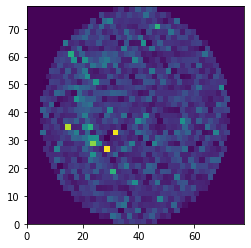

<ipython-input-3-56d343f28860>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


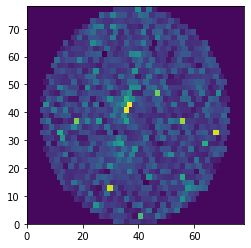

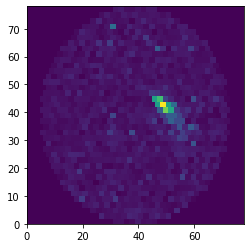

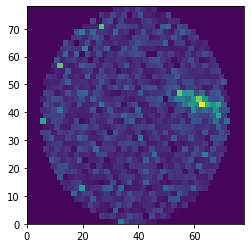

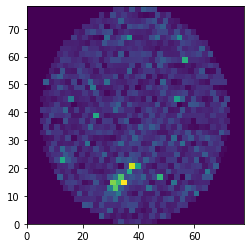

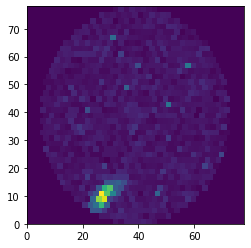

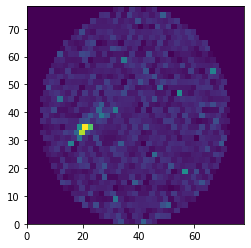

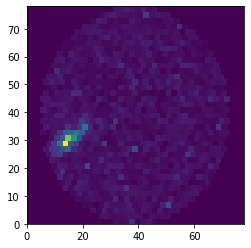

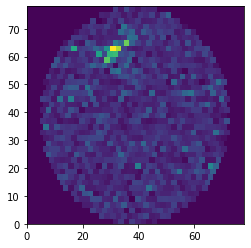

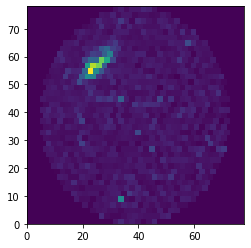

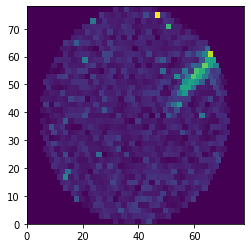

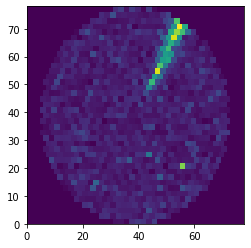

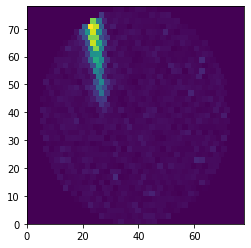

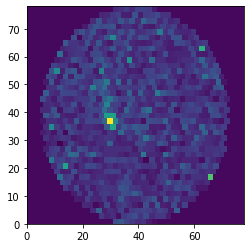

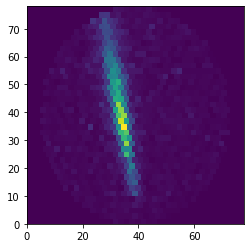

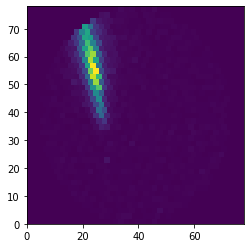

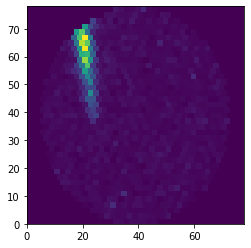

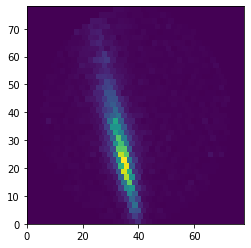

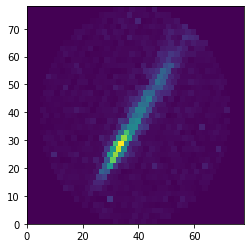

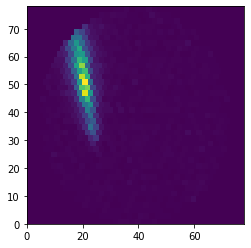

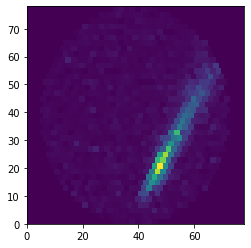

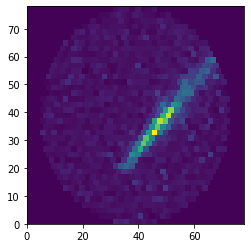

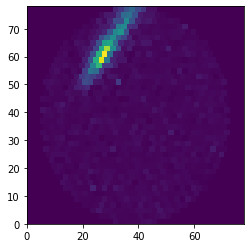

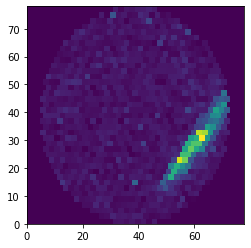

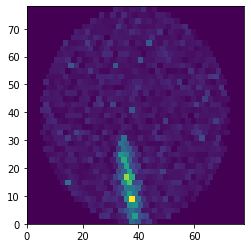

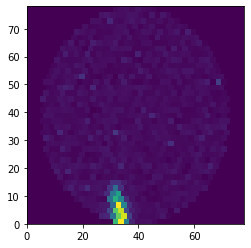

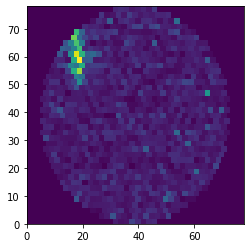

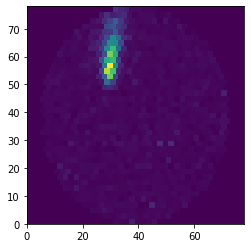

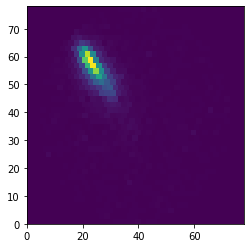

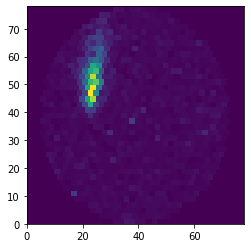

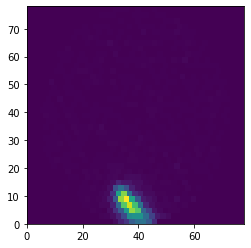

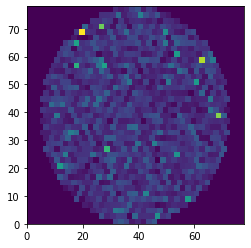

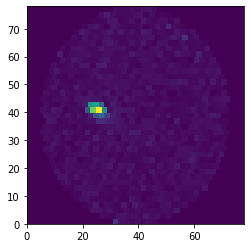

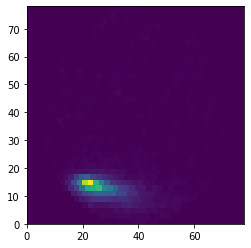

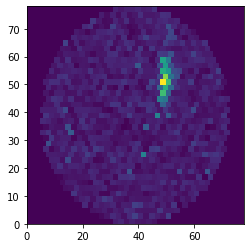

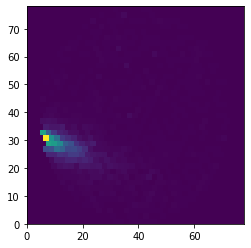

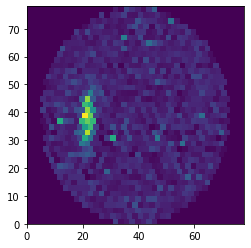

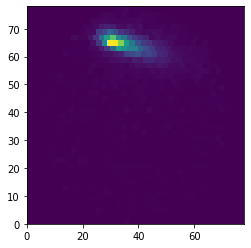

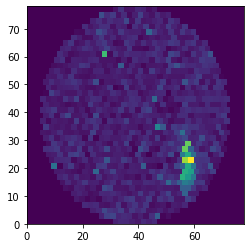

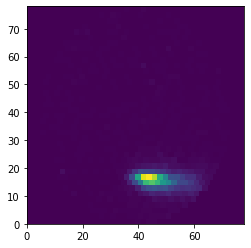

In [3]:
reader = DL1DataReader(["/home/sahil/Documents/gsoc/GA_M*_za05to35_8_821319_Y_w0.h5"], mode = 'stereo')
NUM_IMAGES_TO_PLOT = 20
i = 0
while i < NUM_IMAGES_TO_PLOT:
    example = reader[i]
    image = example[0]  
    plt.figure()
    plt.pcolor(image[0,:,:,0],cmap='viridis')
    plt.axes().set_aspect('equal')
    plt.show()
    plt.close()
    plt.pcolor(image[1,:,:,0],cmap='viridis')
    plt.axes().set_aspect('equal')
    plt.show()
    plt.close()
    i+=1